# [Robust Single Image Super-Resolution via Deep Networks with Sparse Prior](https://ieeexplore.ieee.org/document/7466062)

This notebook is a replication/exploration of the paper linked above. Models were tested on the [Set14](https://link.springer.com/chapter/10.1007/978-3-642-27413-8_47) image set and ABIDEII-BNI1 anatomical scans (subjects 29006 - 29011 for training, 29012 - 29015 for testing). This data can be found [here](http://fcon_1000.projects.nitrc.org/indi/abide/abide_II.html) in the Barrow Neurological Institute `Scan Data` link.

## Setup
There is an assumed organization of the MRI files from ABIDEII-BNI1 in this exercise with respect to this folder. If you have these files in the correct folder, you should receive the same (or similar) results. The files are not provided in this repository for file size reasons. If this is not the case for you, change the references to these files in `SrGen` in the following code to the correct locations.

```
../data/SCN_nifti/
                Raw_train/
                    subject_29006.nii
                    subject_29007.nii
                    subject_29008.nii
                    subject_29009.nii
                    subject_29010.nii
                    subject_29011.nii
                Raw_test/
                    subject_29012.nii
                    subject_29013.nii
                    subject_29014.nii
                    subject_29015.nii
../data/SCN_png/Set14/
                Raw_train/
                    baboon.png
                    barbara.png
                    ...
                    man.png
                Raw_test/
                    monarch.png
                    ...
                    zebra.png
```

### Imports
Like all good python scripts, we import a couple libraries. Note the importing of my own custom class `SrGen` for data loading/saving/organization. That is also in this repository, see the `/gen_utils/SrGen.py` for the source code.

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import os
import sys
import math
sys.path.append('..')
from gen_utils.SrGen import SrGen
import matplotlib.pyplot as plt

## Define Model
The model described in the paper is somewhat difficult to implement, as the description/methods were confusing.

In [3]:
class SCN(nn.Module):
    def __init__(self,sy,sg):
        super().__init__()
        C = 5
        L = 5

        Dx = torch.normal(0,1, size = (25,128))
        Dy = torch.normal(0,1, size = (100,128))
        I = torch.eye(128)

        self.conv = nn.Conv2d(1,100,9, bias = False, stride =1, padding = 6, padding_mode='reflect')
        self.mean2 = nn.Conv2d(1,1,13, bias = False, stride = 1, padding = 6, padding_mode='reflect')
        self.diffms = nn.Conv2d(1,25,9, bias=False, stride = 1, padding=6, padding_mode='reflect')

        self.wd = nn.Conv2d(100,128,1,bias = False, stride = 1)
        self.usd1 = nn.Conv2d(128, 128, 1, bias = False, stride=1)
        self.ud = nn.Conv2d(128,25,1,bias=False,stride=1)
        self.addp = nn.Conv2d(16,1,1, bias = False, stride = 1)

        # Create layers with initialized weights based off of the methods in the manuscript
        self.mean2.weight = torch.nn.Parameter(self.create_gaus(13), requires_grad = False)
        self.diffms.weight = torch.nn.Parameter(self.create_diffms(9,5),requires_grad=False)
        self.wd.weight = torch.nn.Parameter(self.expand_params(C*Dy.T), requires_grad=True)
        self.usd1.weight = torch.nn.Parameter(self.expand_params(I - torch.matmul(Dy.T,Dy)), requires_grad=True)
        self.ud.weight = torch.nn.Parameter(self.expand_params((1/(C*L))*Dx), requires_grad=True)
        self.addp.weight = torch.nn.Parameter(torch.ones(1,16,1,1)*0.06, requires_grad=True)


    def forward(self, x, k, sy=9, sg=5):
        x = x+0.1 #Make sure that when calculating the mean/normalizing you are not dividing by 0

        # Calculate the mean and 
        im_mean = self.mean2(x)
        diffms = self.diffms(x)

        n, c, h, w = x.shape
        x = self.conv(x)

        x = x/torch.linalg.vector_norm(x, ord=2, dim=1, keepdim=True)
        x = self.wd(x)
        z = self.ShLU(x,1)

        # Go through LISTA
        for i in range(k):
            z = self.ShLU(self.usd1(z)+x,1)

        x = self.ud(z)
        x = (x/torch.linalg.vector_norm(x, ord=2, dim=1, keepdim=True))*torch.linalg.vector_norm(diffms, ord=2, dim=1, keepdim=True)*1.1
        x = self.reassemble2(x,im_mean,4)
        x = self.addp(x)
        x = x+im_mean

        return x

    def reassemble2(self, x, im_mean, patch_size):
        img = im_mean
        s, c, h, w = img.shape
        
        # img_stack=torch.zeros(s,25,h,w)
        img_stack=torch.zeros(s,16,h,w)
        
        #go through every sample and reassemble the image
        for q in range(x.shape[0]):
            filt = 0
            for ii in range(patch_size-1, -1, -1):
                for jj in range(patch_size-1, -1, -1):
                    img_stack[q,filt,:,:] = x[q,filt,jj:(jj+h), ii:(ii+w)]
                    filt+=1
        
        return img_stack
    
    # Create
    def create_diffms(self, kern_size, sy=5):
        diffms = torch.zeros(sy**2,1,kern_size,kern_size)
        
        neg = -1*(1/(sy**2))
        pos = 1+neg
        
        border = int((kern_size-sy)/2)
        base = torch.zeros(sy,sy)+neg
        cnt=0
        
        for i in range(sy**2):
            base = torch.zeros(sy**2)+neg
            base[cnt]=pos
            diffms[i,0,border:(kern_size-border),border:(kern_size-border)] = base.reshape([sy,sy])
            cnt+=1
        return diffms
    
    # Create a gaussian kernel with the center being the maximum weight
    def create_gaus(self, kern_size, sy=9,std=2.15):
        n = torch.arange(0,sy)-(sy-1.0)/2.0
        sig2 = 2 * std * std
        gkern1d = torch.exp(-n ** 2 / sig2)
        gkern1d = gkern1d/torch.sum(gkern1d)
        gkern2d = torch.outer(gkern1d, gkern1d)
    

        # Wrap in zeros, if kern_size > sy
        gaussian_filter = torch.zeros(1,1,kern_size,kern_size)
        border = int((kern_size-sy)/2)
        gaussian_filter[0,0,border:(kern_size-border),border:(kern_size-border)] = gkern2d#(sy,std=std)
        return gaussian_filter
        
    
    def fixed_positions(self, tens, mult, sg):
        f, _ , h, w = tens.shape
        new_filt = torch.zeros(f*mult, 1, sg,sg)
        cnt = 0
        filt = 0
        
        for filt in range(f):
            for j in range((sg-w)+1):
                for i in range((sg-h)+1):
                    new_filt[cnt,0,i:i+h,j:j+w] = tens[filt]
                    cnt+=1
        return new_filt
    
    # Expand the dimension of the given tensor
    def expand_params(self,tens):
        return torch.unsqueeze(torch.unsqueeze(tens,2),3)
    
    # ShLU portion of the LISTA loop
    def ShLU(self,a, th):
        return torch.sign(a)*torch.maximum(abs(a)-th, torch.tensor(0))

## Set Optimization Parameters
In the paper they used sub-gradient descent as their optimizer with a loss function of the mean squared error. The did not provide a learning rate, so I found one through some trial and error. This is by no means the best possible learning rate, just what I found which returns positive results.

In [4]:
net = SCN(9,5)

criterion = nn.MSELoss()
optimizer = optim.SGD(
    [
        {"params": net.addp.parameters()},#, "lr": 0.0002, "momentum": 0.00005},
        {"params": net.conv.parameters()},#, "lr": 0.0003, "momentum": 0.0001},
        {"params": net.wd.parameters()},
        {"params": net.usd1.parameters()},
        {"params": net.ud.parameters()},
    ],
    # lr=0.0001, momentum=0.0001
    lr=0.00007, momentum = 0.0001
)

## Generate Data for Training
Only using black and white for the png images

In [5]:
sr_train = SrGen('../data/SCN_png/Set14/Raw_train/','../data/SCN_png/Set14/HR_train_patches/',
        '../data/SCN_png/Set14/LR_train_patches/')

temp = sr_train.get_template()
temp["out_type"] = 'png'
temp["resolution"] = [2,2]
temp["patch"]=[44,44]
temp["step"]=[20,20]
temp["translation"]=[10,10]
temp["rotation"] = 0
temp["scale"] = False
temp["same_size"] = True
temp["unit"] = 'intensity'

sr_train.set_template(temp)

sr_train.run(clear=True, save=True)
#sr_train.match_altered(update=True, paths=False, sort=False)

HR and LR file locations updated


## Create Dataset

In [6]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, sr_class):
        self.sr_class = sr_class

        # In case I forget to run match_altered before pulling the class
        if not sr_class.HR_files:
            sr_class.match_altered(update=True)

    def __len__(self):
        return len(self.sr_class.HR_files)

    def __getitem__(self, index):
        Y, X = self.sr_class.load_image_pair(index)
        X = torch.unsqueeze(torch.tensor(X, dtype=torch.float32),0)
        Y = torch.unsqueeze(torch.tensor(Y, dtype=torch.float32),0)

        return X, Y

## Create Dataloader for Training

In [7]:
params = {'batch_size': 64,
          'shuffle': True,
          'num_workers': 3}

training_set = Dataset(sr_train)
training_generator = torch.utils.data.DataLoader(training_set, **params)

## Training Loop

In [ ]:
from tqdm import tqdm
import time
# Loop over epochs

max_epochs = 40
save_rate = 5 #save a version of the model every 5 epochs
epoch_adjust = 0 #how much to add to the saved files in order to not overwrite
save_prefix = "./SCN_save_"

mean_loss = []

for epoch in tqdm(range(max_epochs)):
    losses = []

    # Training
    count = 0
    for inp, goal in training_generator:
        optimizer.zero_grad()

        output = net(inp,2) # the 2 is the number of iterations in the LISTA network
        output = torch.clamp(output, 0, 255)

        loss = criterion(output,goal)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        count = count+1

    if (epoch % save_rate == 0) or epoch == (max_epochs-1):
        torch.save(net.state_dict(), f'{save_prefix}{epoch+epoch_adjust}.p')
    print(f'\n\n epoch {epoch}, loss mean: {sum(losses)/len(losses)}, loss: {min(losses)}-{max(losses)}\n')
    mean_loss.append(sum(losses)/len(losses))

    # Give computer time to cool down
    time.sleep(90)

### Sanity Check

Text(0.5, 1.0, 'Mean Loss for SCN')

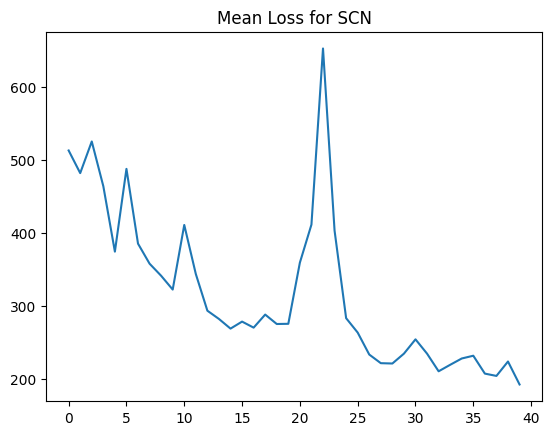

In [16]:
fig, axs = plt.subplots(1, 1)
axs.plot([x for x in range(len(mean_loss))],mean_loss)
axs.set_title('Mean Loss for SCN')

## Testing Model

In [ ]:
# Generate testing data
sr_test = SrGen('../data/SCN_png/Set14/Raw_test/','../data/SCN_png/Set14/HR_test_patches/',
        '../data/SCN_png/Set14/LR_test_patches/')


temp = sr_test.get_template()
temp["out_type"] = 'png'
temp["resolution"] = [2,2]
temp["patch"]=[44,44]
temp["step"]=[20,20]
temp["translation"]=[10,10]
temp["rotation"] = 0
temp["scale"] = False
temp["same_size"] = True
temp["unit"] = 'intensity'

sr_test.set_template(temp)

sr_test.run(clear=True, save=True)
#sr_test.match_altered(update=True, paths=False, sort=False)

In [16]:
params_t = {'batch_size': 1,
        'shuffle': False,
        'num_workers': 2}

testing_set = Dataset(sr_test)
testing_generator = torch.utils.data.DataLoader(testing_set, **params_t)

In [17]:
# Uncomment to load previously trained weights:
# net = SCN(9,5)
# net.load_state_dict(torch.load('./SCN_save_39.p'))


with torch.no_grad():
    # Take low resolution and upscale using bicubic interpolation
    # (which has already been done due to the image generation process)
    # Thus im_l is the bicubic interpolation to compare to...
    idx = 0
    comp={'psnr' : [], 'rmse' : []}
    for inp, goal in testing_generator:
        # Use SR model on low resolution image
        im_h_sr = net(inp,2)
        
        # Get rid of the extra dimensions required for pytorch
        im_h_sr = torch.squeeze(im_h_sr)
        inp = torch.squeeze(inp)

        # Calculate PSNR for bicubic
        im_l = np.rint(np.clip(inp, 0, 255))
        im_h = np.rint(np.clip(goal, 0, 255))
        diff = im_l - im_h
        rmse_b = np.sqrt((diff**2).mean())
        psnr_b = 20*np.log10(255.0/rmse_b)

        print(f'bicubic evaluation for {idx}: rms={rmse_b}, psnr={psnr_b}')

        # Calculate PSNR for SR
        im_h_sr = np.rint( np.clip(im_h_sr, 0, 255))
        im_h = np.rint( np.clip(goal, 0, 255))
        diff = im_h_sr - im_h
        rmse_s = np.sqrt((diff**2).mean())
        psnr_s = 20*np.log10(255.0/rmse_s)
        print(f'SR evaluation for {idx}: rms={rmse_s}, psnr={psnr_s}')

        if idx % 2 == 0:
            if not math.isinf(psnr_s-psnr_b) and not math.isinf(rmse_s-rmse_b):
                comp['psnr'].append(psnr_s-psnr_b)
                comp['rmse'].append(rmse_s-rmse_b)

        idx += 1

bicubic evaluation for 0: rms=0.0, psnr=inf
SR evaluation for 0: rms=0.0, psnr=inf
bicubic evaluation for 1: rms=0.0, psnr=inf
SR evaluation for 1: rms=0.0, psnr=inf
bicubic evaluation for 2: rms=0.0, psnr=inf
SR evaluation for 2: rms=0.0, psnr=inf
bicubic evaluation for 3: rms=0.0, psnr=inf
SR evaluation for 3: rms=0.0, psnr=inf
bicubic evaluation for 4: rms=0.0, psnr=inf
SR evaluation for 4: rms=0.0, psnr=inf
bicubic evaluation for 5: rms=0.0, psnr=inf
SR evaluation for 5: rms=0.0, psnr=inf
bicubic evaluation for 6: rms=0.0, psnr=inf
SR evaluation for 6: rms=0.0, psnr=inf
bicubic evaluation for 7: rms=0.0, psnr=inf
SR evaluation for 7: rms=0.0, psnr=inf
bicubic evaluation for 8: rms=0.0, psnr=inf
SR evaluation for 8: rms=0.0, psnr=inf
bicubic evaluation for 9: rms=0.0, psnr=inf
SR evaluation for 9: rms=0.0, psnr=inf
bicubic evaluation for 10: rms=5.317210674285889, psnr=33.61712646484375
SR evaluation for 10: rms=3.7899386882781982, psnr=36.55815887451172
bicubic evaluation for 11: r

### Sanity check, plot a histogram of how well the SR image performed compared to the Bicubic comparison

Text(0.5, 1.0, 'RMSE: SR - BiC')

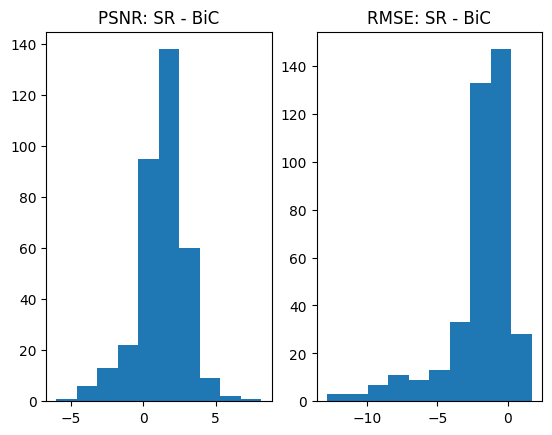

In [18]:
fig, axs = plt.subplots(1, 2)
axs[0].hist([float(x) for x in comp['psnr']], bins=10)
axs[0].set_title('PSNR: SR - BiC')
axs[1].hist([float(x) for x in comp['rmse']], bins=10)
axs[1].set_title('RMSE: SR - BiC')

## Final Application

HR and LR file locations updated
bicubic evaluation for 0: rms=6.417572498321533, psnr=31.983386993408203
SR evaluation for 0: rms=6.027634143829346, psnr=32.52786636352539
bicubic evaluation for 1: rms=13.610873222351074, psnr=25.453083038330078
SR evaluation for 1: rms=10.965042114257812, psnr=27.330598831176758
bicubic evaluation for 2: rms=7.251890182495117, psnr=30.92177963256836
SR evaluation for 2: rms=5.911338806152344, psnr=32.697086334228516
bicubic evaluation for 3: rms=9.87894058227539, psnr=28.236597061157227
SR evaluation for 3: rms=8.004129409790039, psnr=30.06452178955078


Text(0.5, 1.0, 'RMSE: SR - BiC')

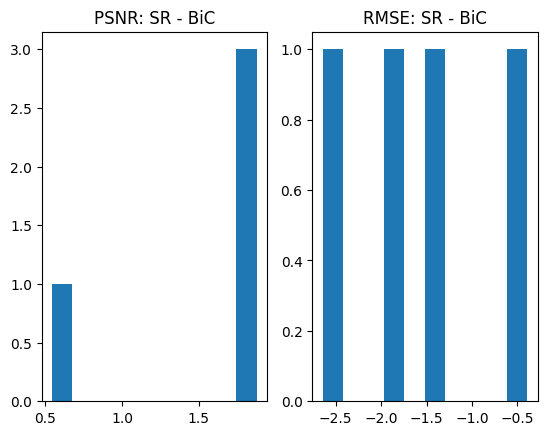

In [19]:
# Generate testing data for both axes
sr = SrGen('../data/SCN_png/Set14/Raw_test/','../data/SCN_png/Set14/HR_Full_test/','../data/SCN_png/Set14/LR_Full_test/')

temp = sr.get_template()
temp['out_type'] = 'png'
temp['resolution'] = [2,2]
temp['patch'] = False
temp['translation'] = [0,0]
temp['rotation'] = [0,0]
temp['keep_blank'] = False
temp['same_size'] = True
temp["unit"] = 'intensity'


#sr.run(clear=True, save=True)
sr.match_altered(update=True, paths=False, sort=False)


params_t = {'batch_size': 1,
        'shuffle': False,
        'num_workers': 2}

full_testing_set = Dataset(sr)### Use the models for SR of MRI images and calculate PSNR
full_img_generator = torch.utils.data.DataLoader(full_testing_set, **params_t)

# Load trained models:
net = SCN(9,5)
net.load_state_dict(torch.load('SCN_save_39.p'))

# Where or not to save the output SR images, if None then don't save any:
save_pre = '../data/SCN_png/Set14/SR_images'


with torch.no_grad():
    idx = 0
    comp={'psnr' : [], 'rmse' : []}
    for inp, goal in full_img_generator:
        # Use SR model on low resolution image
        im_h_sr = net(inp,2)
        
        # Get rid of the extra dimensions required for pytorch
        im_h_sr = torch.squeeze(im_h_sr)
        inp = torch.squeeze(inp)

        # Calculate PSNR for bicubic
        im_l = np.rint( np.clip(inp, 0, 255))
        im_h = np.rint( np.clip(goal, 0, 255))
        diff = im_l - im_h
        rmse_b = np.sqrt((diff**2).mean())
        psnr_b = 20*np.log10(255.0/rmse_b)

        print(f'bicubic evaluation for {idx}: rms={rmse_b}, psnr={psnr_b}')

        # Calculate PSNR for SR
        im_h_sr = np.rint( np.clip(im_h_sr, 0, 255))
        im_h = np.rint( np.clip(goal, 0, 255))
        diff = im_h_sr - im_h
        rmse_s = np.sqrt((diff**2).mean())
        psnr_s = 20*np.log10(255.0/rmse_s)
        print(f'SR evaluation for {idx}: rms={rmse_s}, psnr={psnr_s}')

        if idx % 1 == 0:
            if not math.isinf(psnr_s-psnr_b) and not math.isinf(rmse_s-rmse_b):
                comp['psnr'].append(psnr_s-psnr_b)
                comp['rmse'].append(rmse_s-rmse_b)

        if save_pre:
            # Save the resulting images as .nii files
            os.makedirs(save_pre,exist_ok=True)
            sr.save_image(f'{save_pre}/{sr.LR_files[idx].split("/")[-1]}', im_h_sr.numpy())
        
        idx += 1

fig, axs = plt.subplots(1, 2)
axs[0].hist([float(x) for x in comp['psnr']], bins=10)
axs[0].set_title('PSNR: SR - BiC')
axs[1].hist([float(x) for x in comp['rmse']], bins=10)
axs[1].set_title('RMSE: SR - BiC')

### Compare Slices from SR and HR image

Text(0.5, 1.0, 'Truth')

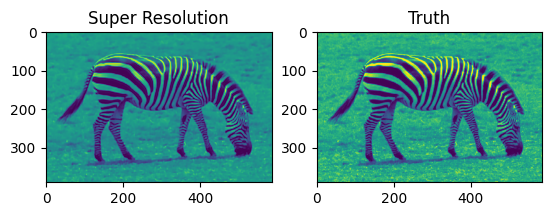

In [20]:
fig, axs = plt.subplots(1, 2)
axs[0].imshow(im_h_sr)
axs[0].set_title('Super Resolution')
axs[1].imshow(sr.load_image(sr.HR_files[-1]))
axs[1].set_title('Truth')

# Conclusion

There we have it! A nice version of the pipeline discussed using Pytorch! In the manuscript they only worked on `.png` images, but I decided to try the model on `.nii` files (MRI's of human brains). See below for the application of that.

Potential directions for future development:
- Determine how well the model works with different MRI collection parameters
- Train it on other medical image types aside from MRI

# Training the Model on Structural MRI Data

In [5]:
net = SCN(9,5)

criterion = nn.MSELoss()
optimizer = optim.SGD(
    [
        {"params": net.addp.parameters()},#, "lr": 0.0002, "momentum": 0.00005},
        {"params": net.conv.parameters()},#, "lr": 0.0003, "momentum": 0.0001},
        {"params": net.wd.parameters()},
        {"params": net.usd1.parameters()},
        {"params": net.ud.parameters()},
    ],
    #lr=0.0001, momentum=0.0001
    lr=0.00007, momentum = 0.0001
)

## Generate Training and Testing MRI Data

In [ ]:
sr_train = SrGen('../data/SCN_nifti/Raw_train/','../data/SCN_nifti/HR_train_patches/','../data/SCN_nifti/LR_train_patches/')

temp = sr_train.get_template()
temp["out_type"] = 'nii'
temp["resolution"] = [2,2,2]
temp["patch"]=[44,44,1]
temp["step"]=[20,20,4]
temp["translation"]=[10,10,10]
temp["rotation"] = 0
temp["scale"] = False
temp["same_size"] = True
temp["unit"] = 'intensity'

sr_train.set_template(temp)

sr_train.run(clear=True, save=True)
#sr_train.match_altered(update=True, paths=False, sort=False)


sr_test = SrGen('../data/SCN_nifti/Raw_test/','../data/SCN_nifti/HR_test_patches/','../data/SCN_nifti/LR_test_patches/')

temp = sr_test.get_template()
temp["out_type"] = 'nii'
temp["resolution"] = [2,2,2]
temp["patch"]=[44,44,1]
temp["step"]=[20,20,4]
temp["translation"]=[10,10,10]
temp["rotation"] = 0
temp["scale"] = False
temp["same_size"] = True
temp["unit"] = 'intensity'

sr_test.set_template(temp)

sr_test.run(clear=True, save=True)
#sr_train.match_altered(update=True, paths=False, sort=False)


## Create Dataset
Different dataset required for handling 3D `nii` samples instead of the 2D `png` samples.

In [22]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, sr_class):
        self.sr_class = sr_class

        # In case I forget to run match_altered before pulling the class
        if not sr_class.HR_files:
            sr_class.match_altered(update=True)

    def __len__(self):
        return len(self.sr_class.HR_files)

    def __getitem__(self, index):
        Y, X = self.sr_class.load_image_pair(index)
        X = torch.unsqueeze(torch.squeeze(torch.tensor(X, dtype=torch.float32),-1),0)
        Y = torch.unsqueeze(torch.squeeze(torch.tensor(Y, dtype=torch.float32),-1),0)

        return X, Y

## Create Dataloaders

In [23]:
params = {'batch_size': 64,
          'shuffle': True,
          'num_workers': 3}

training_set = Dataset(sr_train)
training_generator = torch.utils.data.DataLoader(training_set, **params)

params_t = {'batch_size': 1,
        'shuffle': False,
        'num_workers': 2}

testing_set = Dataset(sr_test)
testing_generator = torch.utils.data.DataLoader(testing_set, **params_t)

## Training Loop

In [ ]:
from tqdm import tqdm
import time
# Loop over epochs

max_epochs = 20
save_rate = 5 #save a version of the model every 5 epochs
epoch_adjust = 0 #how much to add to the saved files in order to not overwrite
save_prefix = "./MRI_SCN_save_"

mean_loss = []

for epoch in tqdm(range(max_epochs)):
    losses = []

    # Training
    count = 0
    for inp, goal in training_generator:
        optimizer.zero_grad()

        output = net(inp,2) # the 2 is the number of iterations in the LISTA network

        loss = criterion(output,goal)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        count = count+1

    if (epoch % save_rate == 0) or epoch == (max_epochs-1):
        torch.save(net.state_dict(), f'{save_prefix}{epoch+epoch_adjust}.p')
    print(f'\n\n epoch {epoch}, loss mean: {sum(losses)/len(losses)}, loss: {min(losses)}-{max(losses)}\n')
    mean_loss.append(sum(losses)/len(losses))

    # Give computer time to cool down
    time.sleep(60)

### Sanity Check

Text(0.5, 1.0, 'Mean Loss for SCN')

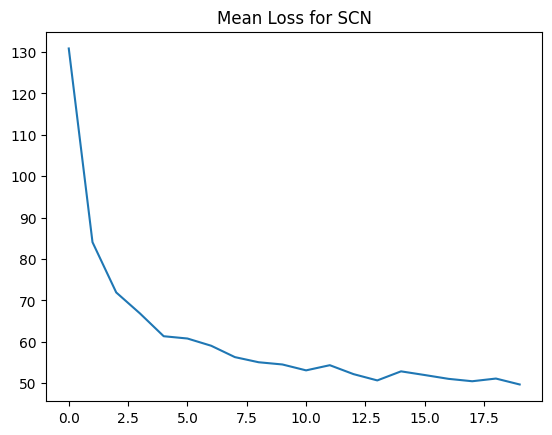

In [27]:
fig, axs = plt.subplots(1, 1)
axs.plot([x for x in range(len(mean_loss))],mean_loss)
axs.set_title('Mean Loss for SCN')

## Testing Loop

In [28]:
with torch.no_grad():
    # Take low resolution and upscale using bicubic interpolation
    # (which has already been done due to the image generation process)
    # Thus im_l is the bicubic interpolation to compare to...
    idx = 0
    comp={'psnr' : [], 'rmse' : []}
    for inp, goal in testing_generator:
        # Use SR model on low resolution image
        #im_h_sr = net(torch.unsqueeze(torch.unsqueeze(torch.tensor(im_l, dtype=torch.float32),0),0),2)
        im_h_sr = net(inp,2)
        
        # Get rid of the extra dimensions required for pytorch
        im_h_sr = torch.squeeze(im_h_sr)
        inp = torch.squeeze(inp)

        # Calculate PSNR for bicubic
        diff = inp - goal
        rmse_b = np.sqrt((diff**2).mean())
        psnr_b = 20*np.log10(goal.max()/rmse_b)

        print(f'bicubic evaluation for {idx}: rms={rmse_b}, psnr={psnr_b}')

        # Calculate PSNR for SR
        diff = im_h_sr - goal
        rmse_s = np.sqrt((diff**2).mean())
        psnr_s = 20*np.log10(goal.max()/rmse_s)
        print(f'SR evaluation for {idx}: rms={rmse_s}, psnr={psnr_s}')

        if idx % 2 == 0:
            if not math.isinf(psnr_s-psnr_b) and not math.isinf(rmse_s-rmse_b):
                comp['psnr'].append(psnr_s-psnr_b)
                comp['rmse'].append(rmse_s-rmse_b)

        idx += 1

bicubic evaluation for 0: rms=4.671670436859131, psnr=27.27903175354004
SR evaluation for 0: rms=4.078692436218262, psnr=28.458057403564453
bicubic evaluation for 1: rms=5.415585994720459, psnr=25.23979377746582
SR evaluation for 1: rms=4.2598724365234375, psnr=27.324771881103516
bicubic evaluation for 2: rms=5.066115379333496, psnr=27.120454788208008
SR evaluation for 2: rms=3.988023281097412, psnr=29.198802947998047
bicubic evaluation for 3: rms=5.185257434844971, psnr=27.288217544555664
SR evaluation for 3: rms=3.7489676475524902, psnr=30.105390548706055
bicubic evaluation for 4: rms=5.355075359344482, psnr=26.935626983642578
SR evaluation for 4: rms=4.279836177825928, psnr=28.882396697998047
bicubic evaluation for 5: rms=5.038131237030029, psnr=27.243770599365234
SR evaluation for 5: rms=3.6057422161102295, psnr=30.149267196655273
bicubic evaluation for 6: rms=5.628078937530518, psnr=26.20675277709961
SR evaluation for 6: rms=4.281525135040283, psnr=28.581985473632812
bicubic evalu

Text(0.5, 1.0, 'RMSE: SR - BiC')

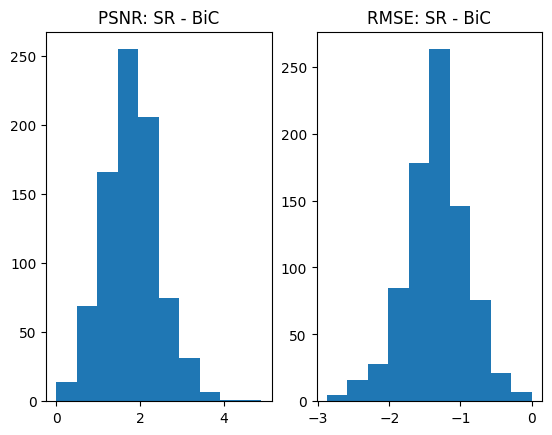

In [29]:
# Sanity check, plot a histogram of how well the SR image performed compared to the Bicubic comparison
fig, axs = plt.subplots(1, 2)
axs[0].hist([float(x) for x in comp['psnr']], bins=10)
axs[0].set_title('PSNR: SR - BiC')
axs[1].hist([float(x) for x in comp['rmse']], bins=10)
axs[1].set_title('RMSE: SR - BiC')

## Final Application

In [24]:
sr = SrGen('../data/SCN_nifti/Raw_test/','../data/SCN_nifti/HR_Full_test/','../data/SCN_nifti/LR_Full_test/')

temp = sr_test.get_template()
temp["out_type"] = 'nii'
temp["resolution"] = [2,2,2]
temp["patch"]=[-1,-1,1]
temp['blank_ratio']= 0.7 #there are a lot of blank slices
temp["step"]=[10,10,1]
temp["keep_blank"]=True
temp["translation"]=0
temp["rotation"] = 0
temp["scale"] = False
temp["same_size"] = True
temp["unit"] = 'intensity'

sr.set_template(temp)

#sr.run(clear=True, save=True)
sr.match_altered(update=True, paths=False, sort=False)


params_t = {'batch_size': 1,
        'shuffle': False,
        'num_workers': 2}

full_testing_set = Dataset(sr)### Use the models for SR of MRI images and calculate PSNR
full_img_generator = torch.utils.data.DataLoader(full_testing_set, **params_t)
# Load trained models:
net = SCN(9,5)
net.load_state_dict(torch.load('MRI_SCN_save_19.p'))

# Where or not to save the output SR images, if None then don't save any:
save_pre = '../data/SCN_nifti/SR_images'


with torch.no_grad():
    # Take low resolution and upscale using bicubic interpolation
    # (which has already been done due to the image generation process)
    # Thus im_l is the bicubic interpolation to compare to...
    idx = 0
    comp={'psnr' : [], 'rmse' : []}
    for inp, goal in full_img_generator:
        # Use SR model on low resolution image
        im_h_sr = net(inp,2)
        
        # Get rid of the extra dimensions required for pytorch
        im_h_sr = torch.squeeze(im_h_sr)
        inp = torch.squeeze(inp)

        # Calculate PSNR for bicubic
        diff = inp - goal
        rmse_b = np.sqrt((diff**2).mean())
        psnr_b = 20*np.log10(goal.max()/rmse_b)

        print(f'bicubic evaluation for {idx}: rms={rmse_b}, psnr={psnr_b}')

        # Calculate PSNR for SR
        diff = im_h_sr - goal
        rmse_s = np.sqrt((diff**2).mean())
        psnr_s = 20*np.log10(goal.max()/rmse_s)
        print(f'SR evaluation for {idx}: rms={rmse_s}, psnr={psnr_s}')

        if idx % 2 == 0:
            if not math.isinf(psnr_s-psnr_b) and not math.isinf(rmse_s-rmse_b):
                comp['psnr'].append(psnr_s-psnr_b)
                comp['rmse'].append(rmse_s-rmse_b)

        if save_pre:
            im_h_sr = torch.unsqueeze(im_h_sr,-1)
            print(im_h_sr.shape)
            # Save the resulting images as .nii files
            os.makedirs(save_pre,exist_ok=True)
            sr.save_image(f'{save_pre}/{sr.LR_files[idx].split("/")[-1]}', im_h_sr.numpy())
        
        idx += 1

HR and LR file locations updated
bicubic evaluation for 0: rms=7.216855525970459, psnr=27.12991714477539
SR evaluation for 0: rms=6.309596538543701, psnr=28.296844482421875
torch.Size([192, 256, 1])
bicubic evaluation for 1: rms=6.785760402679443, psnr=27.61178207397461
SR evaluation for 1: rms=4.801056385040283, psnr=30.617015838623047
torch.Size([192, 256, 1])
bicubic evaluation for 2: rms=5.944597244262695, psnr=28.435544967651367
SR evaluation for 2: rms=4.395853519439697, psnr=31.05712890625
torch.Size([192, 256, 1])
bicubic evaluation for 3: rms=5.955430507659912, psnr=32.83454513549805
SR evaluation for 3: rms=4.615852355957031, psnr=35.04777145385742
torch.Size([192, 256, 1])
bicubic evaluation for 4: rms=5.127467155456543, psnr=30.5628662109375
SR evaluation for 4: rms=4.624680042266846, psnr=31.45928955078125
torch.Size([192, 256, 1])
bicubic evaluation for 5: rms=5.940670013427734, psnr=28.97762107849121
SR evaluation for 5: rms=4.347783088684082, psnr=31.68897247314453
torc

### Sanity check, plot a histogram of how well the SR image performed compared to the Bicubic comparison

Text(0.5, 1.0, 'RMSE: SR - BiC')

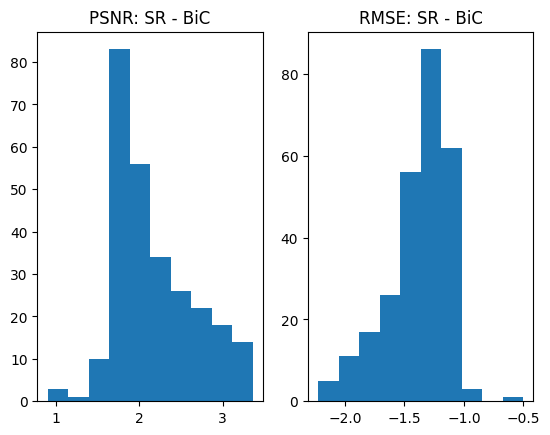

In [25]:
fig, axs = plt.subplots(1, 2)
axs[0].hist([float(x) for x in comp['psnr']], bins=10)
axs[0].set_title('PSNR: SR - BiC')
axs[1].hist([float(x) for x in comp['rmse']], bins=10)
axs[1].set_title('RMSE: SR - BiC')

### Compare Slices from SR and LR image

Text(0.5, 1.0, 'Truth')

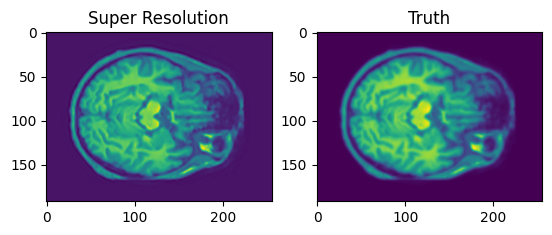

In [26]:
fig, axs = plt.subplots(1, 2)
axs[0].imshow(im_h_sr)
axs[0].set_title('Super Resolution')
axs[1].imshow(sr.load_image(sr.LR_files[-1]))
axs[1].set_title('Truth')